Install dependencies

In [88]:
!pip install keybert
!pip install evaluate
!pip install transformers
!pip install bert-extractive-summarizer
!pip install rouge_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Import libraries

In [89]:
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from keybert import KeyBERT
import spacy
import collections
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import rcParams
from wordcloud import WordCloud, STOPWORDS
import evaluate
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import pipeline
from summarizer.bert import Summarizer

In [90]:
data = pd.read_json('Appliances_5.json', lines=True)

data = data[['reviewerID','reviewerName','asin','reviewText','summary']]
print(data)

          reviewerID     reviewerName        asin  \
0     A34A1UP40713F8    James. Backus  B00009W3I4   
1     A1AHW6I678O6F2           kevin.  B00009W3PA   
2      A8R48NKTGCJDQ        CDBrannom  B00009W3PA   
3      AR3OHHHW01A8E  Calvin E Reames  B00009W3PA   
4     A2CIEGHZ7L1WWR   albert j. kong  B00009W3PA   
...              ...              ...         ...   
2272  A2B2JVUX5YN8RU            Caleb  B0006GVNOA   
2273  A1IT56MV1C09VS    Looneypenguin  B0006GVNOA   
2274  A13391AZAFJ67K           Fred A  B00570RQ0A   
2275  A2V0JXLJ9VCNNX  Amazon Customer  B00570RQ0A   
2276  A3GP2HMB2AFOKF             Juan  B00W4YKCGC   

                                             reviewText  \
0     I like this as a vent as well as something tha...   
1                                             good item   
2                        Fit my new LG dryer perfectly.   
3                        Good value for electric dryers   
4                     Price and delivery was excellent.   
...      

Sentiment Analysis Test

In [91]:
nltk.download('vader_lexicon')

# Load the VADER model
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [92]:
sentence = data['reviewText'][10]

In [93]:
print("Review:", sentence)

Review: We would give less than 1 star if possible DONT BUY THIS PRODUCT.  The ice machine stopped working four hours after we used it the first time.  We notified New Air and they stated they would not honor their one year warranty because "an authorized dealer didn't sell".  We bought this product on Amazon and never even thought we would have to cross check our purchase with the manufacturer.  NewAir does not stand by their products and they will use any method to get out of honoring their warranty.  I have a $200 piece of junk now, I will NEVER buy another NewAir product again.


In [94]:
def get_sentiment(text):
    temp = sid.polarity_scores(text)
    if temp['compound'] >= 0.05:
      return 'Positive'
    elif temp['compound'] <= - 0.05:
      return'Negative'
    else:
      return'Neutral'

print("Sentiment:", get_sentiment(sentence))

Sentiment: Positive


Key Phrase extraction

In [95]:
kb_model = KeyBERT(model='all-mpnet-base-v2')
def get_summary(text):
  keywords = kb_model.extract_keywords(text, 

                                      keyphrase_ngram_range=(1,3), 

                                      stop_words='english', 

                                      highlight=False,

                                      top_n=5)

  keywords_list= list(dict(keywords).keys())
  return keywords_list

print("Original review:",sentence)
print("Key phrases:",get_summary(sentence))

Original review: We would give less than 1 star if possible DONT BUY THIS PRODUCT.  The ice machine stopped working four hours after we used it the first time.  We notified New Air and they stated they would not honor their one year warranty because "an authorized dealer didn't sell".  We bought this product on Amazon and never even thought we would have to cross check our purchase with the manufacturer.  NewAir does not stand by their products and they will use any method to get out of honoring their warranty.  I have a $200 piece of junk now, I will NEVER buy another NewAir product again.
Key phrases: ['product ice machine', 'ice machine', 'ice machine stopped', 'product ice', 'buy product ice']


Adjective extraction

In [96]:
def extract_adj(sentence):
  # Load the pre-trained English language model
  nlp = spacy.load("en_core_web_sm")

  # Process the sentence with spaCy
  doc = nlp(sentence)

  # Extract all the adjectives in the sentence
  adjectives = [token.text for token in doc if token.pos_ == "ADJ"]

  # Print the list of adjectives
  return adjectives

print("Original review:",sentence)
print("Adjectives:",extract_adj(sentence))

Original review: We would give less than 1 star if possible DONT BUY THIS PRODUCT.  The ice machine stopped working four hours after we used it the first time.  We notified New Air and they stated they would not honor their one year warranty because "an authorized dealer didn't sell".  We bought this product on Amazon and never even thought we would have to cross check our purchase with the manufacturer.  NewAir does not stand by their products and they will use any method to get out of honoring their warranty.  I have a $200 piece of junk now, I will NEVER buy another NewAir product again.
Adjectives: ['less', 'possible', 'first', 'authorized', 'NewAir']


Word Cloud

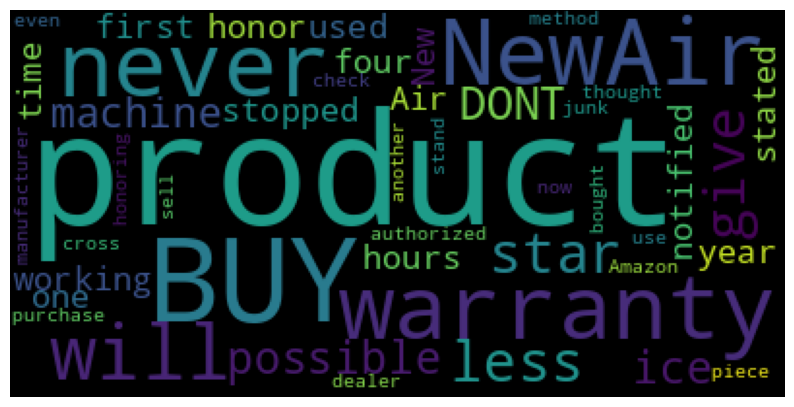

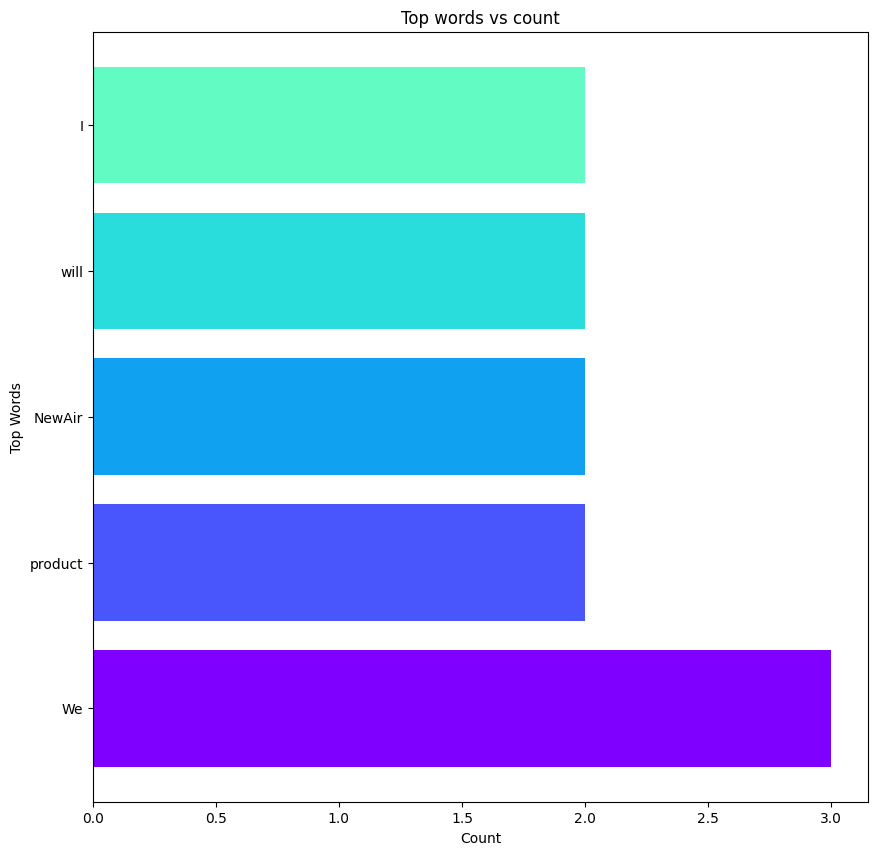

In [97]:
stopwords = STOPWORDS
word_cloud = WordCloud(stopwords=stopwords, background_color="black", max_words=1000).generate(sentence)
rcParams['figure.figsize'] = 10, 10
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

filtered_words = [word for word in sentence.split() if word not in stopwords]
counted_words = collections.Counter(filtered_words)
words = []
counts = []
for letter, count in counted_words.most_common(5):
    words.append(letter)
    counts.append(count)

colors = cm.rainbow(np.linspace(0, 1, 10))
rcParams['figure.figsize'] = 10, 10
plt.title('Top words vs count')
plt.xlabel('Count')
plt.ylabel('Top Words')
plt.barh(words, counts, color=colors)
plt.show()

Extractive Summarization (T5 Base vs BERT)

In [98]:
rouge_score = evaluate.load("rouge")
def calcRougeScore(generated_summary, reference_summary):
  scores = rouge_score.compute(
      predictions=[generated_summary], references=[reference_summary]
  )
  return scores

In [99]:
model = AutoModelForSeq2SeqLM.from_pretrained('t5-base')
tokenizer = AutoTokenizer.from_pretrained('t5-base')

In [100]:
summaryList = []
tokens_input = tokenizer.encode("summarize: " + sentence,
                              return_tensors='pt',
                              max_length=tokenizer.model_max_length,
                              truncation=True)
summary_ids = model.generate(tokens_input, 
                          max_length=15, length_penalty=5, 
                          num_beams=2, repetition_penalty=5.0)
summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
summaryList.append(summary)

print("Original review:",sentence)
print("Summary:",summary)
print(calcRougeScore(sentence, summary))

Original review: We would give less than 1 star if possible DONT BUY THIS PRODUCT.  The ice machine stopped working four hours after we used it the first time.  We notified New Air and they stated they would not honor their one year warranty because "an authorized dealer didn't sell".  We bought this product on Amazon and never even thought we would have to cross check our purchase with the manufacturer.  NewAir does not stand by their products and they will use any method to get out of honoring their warranty.  I have a $200 piece of junk now, I will NEVER buy another NewAir product again.
Summary: the ice machine stopped working four hours after we used it the first
{'rouge1': 0.21848739495798317, 'rouge2': 0.20512820512820512, 'rougeL': 0.21848739495798317, 'rougeLsum': 0.21848739495798317}


In [101]:
bert_model = Summarizer()
result = bert_model(sentence, num_sentences=1)
full = ''.join(result)

print("Original review:",sentence)
print("Summary:",full)
print(calcRougeScore(sentence, full))

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Original review: We would give less than 1 star if possible DONT BUY THIS PRODUCT.  The ice machine stopped working four hours after we used it the first time.  We notified New Air and they stated they would not honor their one year warranty because "an authorized dealer didn't sell".  We bought this product on Amazon and never even thought we would have to cross check our purchase with the manufacturer.  NewAir does not stand by their products and they will use any method to get out of honoring their warranty.  I have a $200 piece of junk now, I will NEVER buy another NewAir product again.
Summary: We would give less than 1 star if possible DONT BUY THIS PRODUCT.
{'rouge1': 0.21848739495798317, 'rouge2': 0.20512820512820512, 'rougeL': 0.21848739495798317, 'rougeLsum': 0.21848739495798317}


Fine-tuned Abstractive Summarization defined in Summarization (TensorFlow).ipynb

In [102]:
hub_model_id = "jovianjaison/mt5-small-finetuned-amazon-en-es"
summarizer = pipeline("summarization", model=hub_model_id)

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
All model checkpoint layers were used when initializing TFMT5ForConditionalGeneration.

All the layers of TFMT5ForConditionalGeneration were initialized from the model checkpoint at jovianjaison/mt5-small-finetuned-amazon-en-es.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMT5ForConditionalGeneration for predictions without further training.


In [103]:
summary = summarizer(sentence)[0]["summary_text"]

print("Original review:",sentence)
print("Summary:",summary)
print(calcRougeScore(sentence, summary))

Original review: We would give less than 1 star if possible DONT BUY THIS PRODUCT.  The ice machine stopped working four hours after we used it the first time.  We notified New Air and they stated they would not honor their one year warranty because "an authorized dealer didn't sell".  We bought this product on Amazon and never even thought we would have to cross check our purchase with the manufacturer.  NewAir does not stand by their products and they will use any method to get out of honoring their warranty.  I have a $200 piece of junk now, I will NEVER buy another NewAir product again.
Summary: Not a $200 piece of junk
{'rouge1': 0.10714285714285715, 'rouge2': 0.07272727272727274, 'rougeL': 0.10714285714285715, 'rougeLsum': 0.10714285714285715}
